In [1]:
##Notebook for Top Scorer and Total Points

In [2]:
# Cell 1: Imports
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
from datetime import datetime
import os
import sys

print("Imports completed.")

Imports completed.


In [3]:
# Cell 2: Setup and Configuration
# ==================================================

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

# Path Setup
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

PROJECT_ROOT = Path('../../') 
DATASETS_DIR = PROJECT_ROOT / 'Task_Files/datasets'
DATA_DIR = PROJECT_ROOT / 'Task_Files/data'
MODELS_DIR = Path('models')
REPORTS_DIR = PROJECT_ROOT / 'reports'
VISUALIZATIONS_DIR = PROJECT_ROOT / 'visualizations'

# Ensure output directories exist
for d in [MODELS_DIR, REPORTS_DIR, VISUALIZATIONS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Specific Data Paths
POINTS_DATA_PATH = DATASETS_DIR / 'EPL(Overall Points & Ranking).csv'
SCORER_DATA_PATH = DATASETS_DIR / 'Goals & Assist_selected.xlsx'

print("="*80)
print("SETUP COMPLETED")
print("="*80)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Datasets Dir: {DATASETS_DIR}")
print(f"Models Dir: {MODELS_DIR}")
print(f"Points Data Path: {POINTS_DATA_PATH}")
print(f"Scorer Data Path: {SCORER_DATA_PATH}")

SETUP COMPLETED
Project Root: ..\..
Datasets Dir: ..\..\Task_Files\datasets
Models Dir: models
Points Data Path: ..\..\Task_Files\datasets\EPL(Overall Points & Ranking).csv
Scorer Data Path: ..\..\Task_Files\datasets\Goals & Assist_selected.xlsx


## 2. Total Points Prediction

### 2.1. Data Loading and Engineering (Total Points)

In [4]:
# Cell 3: Data Loading (Total Points)
# ==================================================

print("\n" + "="*80)
print("DATA LOADING - TOTAL POINTS")
print("="*80)

if not POINTS_DATA_PATH.exists():
    # Fallback logic if needed, or just raise error
    print(f"⚠ File not found: {POINTS_DATA_PATH}")
    # Try alternative name if known, or raise
    raise FileNotFoundError(f"File not found: {POINTS_DATA_PATH}")

print(f"Loading data from: {POINTS_DATA_PATH}")
try:
    # 0xff at start suggests UTF-16
    df_points = pd.read_csv(POINTS_DATA_PATH, encoding='utf-16', on_bad_lines='skip')
    print("✓ Loaded with UTF-16 encoding")
except Exception as e:
    print(f"⚠ UTF-16 failed: {e}")
    try:
        df_points = pd.read_csv(POINTS_DATA_PATH, encoding='utf-8', on_bad_lines='skip')
        print("✓ Loaded with UTF-8 encoding")
    except Exception as e:
        print(f"⚠ UTF-8 failed: {e}")
        print("Trying 'latin1'...")
        df_points = pd.read_csv(POINTS_DATA_PATH, encoding='latin1', on_bad_lines='skip')
        print("✓ Loaded with Latin1 encoding")

# Standardize columns
df_points.columns = df_points.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('+', 'plus')

print(f"Data Shape: {df_points.shape}")
print("\nColumns:", df_points.columns.tolist())

# Quality Check
print("\nData Quality Check:")
print(f"Missing Values: {df_points.isnull().sum().sum()}")
print(f"Duplicates: {df_points.duplicated().sum()}")
print(f"Data Types:\n{df_points.dtypes.value_counts()}")


DATA LOADING - TOTAL POINTS
Loading data from: ..\..\Task_Files\datasets\EPL(Overall Points & Ranking).csv
✓ Loaded with UTF-16 encoding
Data Shape: (646, 13)

Columns: ['season_end_year', 'team', 'position', 'champion', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points', 'notes']

Data Quality Check:
Missing Values: 922
Duplicates: 0
Data Types:
int64      10
object      2
float64     1
Name: count, dtype: int64


In [5]:
# Cell 3.1: Data Cleaning (Total Points)
# ==================================================

print("\n" + "="*80)
print("DATA CLEANING - TOTAL POINTS")
print("="*80)

# 1. Handle Duplicates
initial_rows = df_points.shape[0]
df_points = df_points.drop_duplicates()
duplicates_removed = initial_rows - df_points.shape[0]
print(f"Removed {duplicates_removed} duplicate rows.")

# 2. Handle Missing Values
# Check for missing values in critical columns
# Adjust column names based on actual data
critical_cols = []
if 'season' in df_points.columns:
    critical_cols.append('season')
elif 'season_end_year' in df_points.columns:
    critical_cols.append('season_end_year')

if 'team' in df_points.columns:
    critical_cols.append('team')

target_col = 'total_points'
if 'points' in df_points.columns:
    target_col = 'points'
elif 'pts' in df_points.columns:
    target_col = 'pts'

if target_col in df_points.columns:
    critical_cols.append(target_col)

print(f"Checking critical columns: {critical_cols}")
missing_critical = df_points[critical_cols].isnull().sum()
print("\nMissing values in critical columns:")
print(missing_critical[missing_critical > 0])

# Drop rows where target is missing
if target_col in df_points.columns:
    missing_target = df_points[target_col].isnull().sum()
    if missing_target > 0:
        print(f"Dropping {missing_target} rows with missing target variable '{target_col}'.")
        df_points = df_points.dropna(subset=[target_col])

# Impute other missing values if necessary (example: numeric with median, categorical with mode)
numeric_cols = df_points.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_points[col].isnull().sum() > 0:
        median_val = df_points[col].median()
        df_points[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in '{col}' with median: {median_val}")

categorical_cols = df_points.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_points[col].isnull().sum() > 0:
        mode_val = df_points[col].mode()[0]
        df_points[col].fillna(mode_val, inplace=True)
        print(f"Imputed missing values in '{col}' with mode: {mode_val}")

print(f"\nData Shape after cleaning: {df_points.shape}")


DATA CLEANING - TOTAL POINTS
Removed 0 duplicate rows.
Checking critical columns: ['season_end_year', 'team', 'points']

Missing values in critical columns:
Series([], dtype: int64)
Imputed missing values in 'champion' with median: 0.0
Imputed missing values in 'notes' with mode: ΓåÆ Champions League via league finish

Data Shape after cleaning: (646, 13)


In [6]:
# Cell 3.2: Outlier Detection and Handling (Total Points)
# ==================================================

print("\n" + "="*80)
print("OUTLIER HANDLING - TOTAL POINTS")
print("="*80)

def handle_outliers_iqr(df, columns, multiplier=1.5):
    """
    Detects and handles outliers using the IQR method.
    Caps outliers at the lower and upper bounds.
    """
    df_clean = df.copy()
    outlier_report = []
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Count outliers
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        count = outliers.shape[0]
        
        if count > 0:
            # Cap outliers
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
            
            outlier_report.append({
                'Column': col,
                'Outliers Detected': count,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound
            })
            
    return df_clean, pd.DataFrame(outlier_report)

# Select numeric columns for outlier detection (exclude target if you want to keep true extremes)
# Typically we clean features, but sometimes target too. Let's clean features.
numeric_features = df_points.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target and potential ID-like columns or years
exclude_cols = ['total_points', 'points', 'pts', 'season', 'season_end_year', 'rank', 'position', 'champion'] 
cols_to_check = [c for c in numeric_features if c not in exclude_cols]

print(f"Checking for outliers in {len(cols_to_check)} columns...")
print(f"Columns to check: {cols_to_check}")

df_points, outlier_summary = handle_outliers_iqr(df_points, cols_to_check)

if not outlier_summary.empty:
    print("\nOutlier Summary (Capped at 1.5*IQR):")
    print(outlier_summary.to_string(index=False))
else:
    print("\nNo outliers detected in selected columns.")

print(f"\nData Shape after outlier handling: {df_points.shape}")


OUTLIER HANDLING - TOTAL POINTS
Checking for outliers in 7 columns...
Columns to check: ['played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd']

Outlier Summary (Capped at 1.5*IQR):
Column  Outliers Detected  Lower Bound  Upper Bound
played                 66       38.000       38.000
   won                  3       -2.000       30.000
    gf                 13       11.375       90.375
    ga                  8       17.875       84.875
    gd                 11      -65.000       63.000

Data Shape after outlier handling: (646, 13)



EDA - TOTAL POINTS
Target Column: 'points'


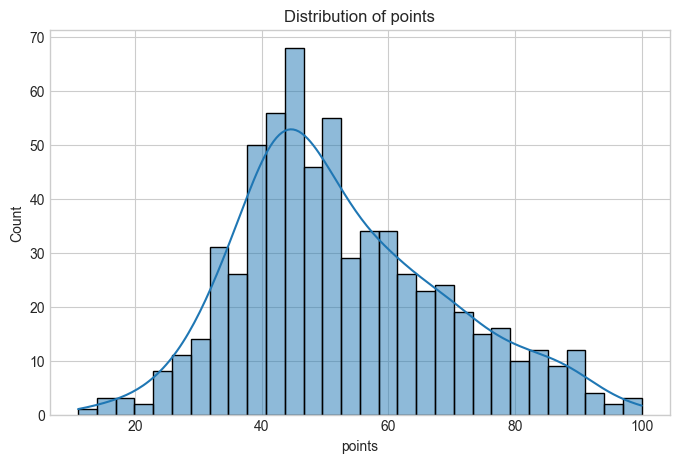


points Statistics:
count    646.000000
mean      52.654799
std       16.499190
min       11.000000
25%       41.000000
50%       50.000000
75%       63.000000
max      100.000000
Name: points, dtype: float64


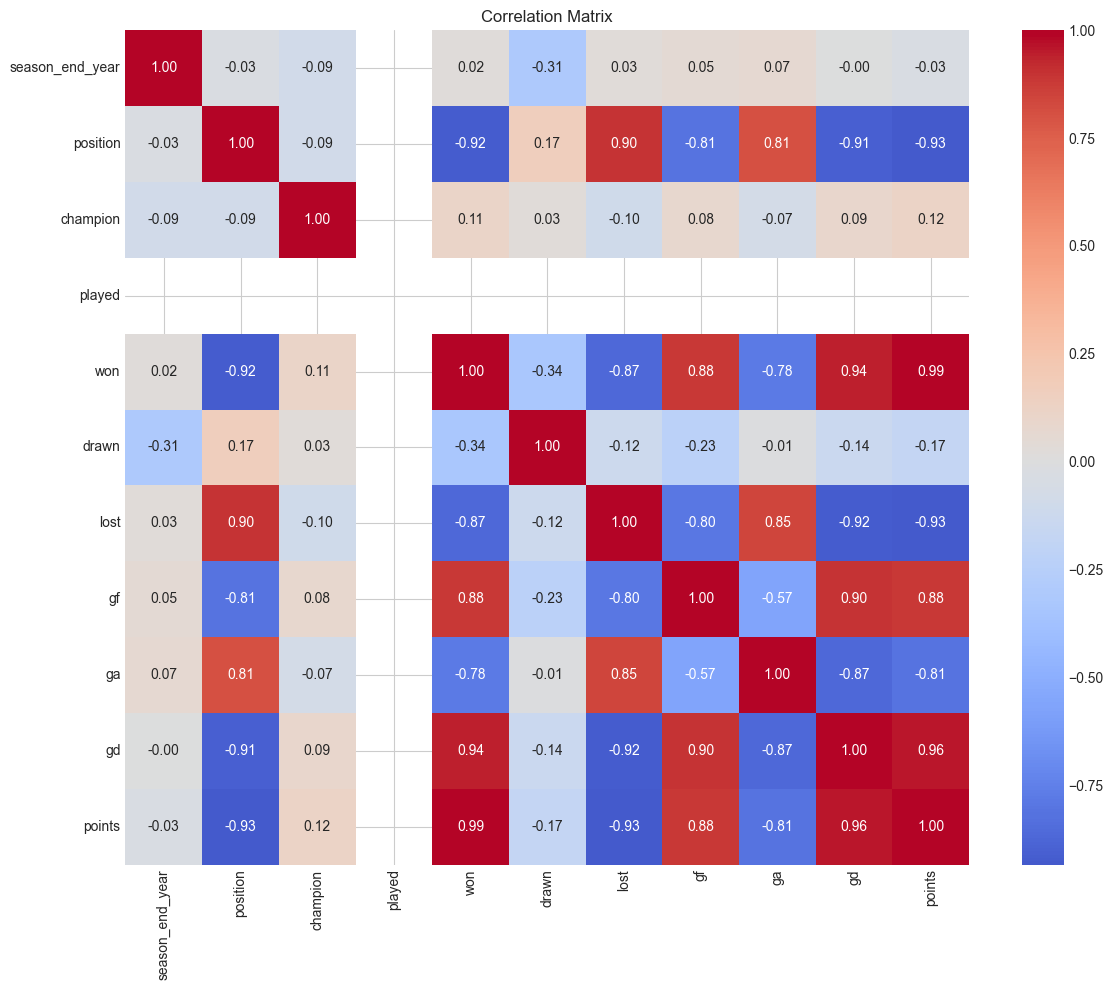


Top correlations with points:
points             1.000000
won                0.985033
gd                 0.958848
gf                 0.882735
champion           0.119475
season_end_year   -0.031320
drawn             -0.174116
ga                -0.813223
lost              -0.932318
position          -0.934208
Name: points, dtype: float64


In [7]:
# Cell 4: EDA (Total Points)
# ==================================================

print("\n" + "="*80)
print("EDA - TOTAL POINTS")
print("="*80)

# Identify target column
points_target = None
for col in ['total_points', 'points', 'pts', 'target_total_points']:
    if col in df_points.columns:
        points_target = col
        break

if points_target:
    print(f"Target Column: '{points_target}'")
    
    # Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df_points[points_target], kde=True, bins=30)
    plt.title(f'Distribution of {points_target}')
    plt.xlabel(points_target)
    plt.show()
    
    print(f"\n{points_target} Statistics:")
    print(df_points[points_target].describe())
    
    # Correlations
    numeric_df = df_points.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        plt.figure(figsize=(12, 10))
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop correlations with {points_target}:")
        print(corr_matrix[points_target].sort_values(ascending=False).head(10))
else:
    print("! WARNING: No points target column found.")

### 2.2. Feature Engineering (Total Points)

In [8]:
# Cell 5: Feature Engineering (Total Points)
# ==================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("FEATURE ENGINEERING - TOTAL POINTS")
print("="*80)

if points_target:
    data = df_points.copy()
    
    # Leakage Removal
    leakage_cols = ['rank', 'position', 'target_champion', 'target_top_4', 
                    'target_top_6', 'target_relegated', 'target_league_position', 
                    'champion', 'notes', 'matches_played', 'starts', 'minutes', '90s_played',
                    'won', 'drawn', 'lost']
    
    # Drop non-predictive columns
    drop_cols = ['team', 'player', 'name', 'date', 'team_name', 'nation', 'unnamed:_0'] + leakage_cols
    
    y = data[[points_target]]
    X = data.drop(columns=[points_target])
    
    # Drop irrelevant columns
    dropped = [c for c in drop_cols if c in X.columns]
    X = X.drop(columns=dropped, errors='ignore')
    
    print(f"Excluded Columns ({len(dropped)}): {dropped}")
    
    # Handle missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isnull().any():
            X[col].fillna(X[col].median(), inplace=True)
            
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    for col in cat_cols:
        if X[col].isnull().any():
            X[col].fillna('Unknown', inplace=True)
            
    # Encode categorical
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        
    # Split
    if 'season' in df_points.columns:
        print("Using Temporal Split based on 'season'...")
        seasons = sorted(df_points['season'].unique())
        split_idx = int(len(seasons) * 0.8)
        train_seasons = seasons[:split_idx]
        test_seasons = seasons[split_idx:]
        
        train_mask = df_points['season'].isin(train_seasons)
        test_mask = df_points['season'].isin(test_seasons)
        
        # Align masks with data index (since we dropped NaNs)
        train_mask = train_mask.loc[data.index]
        test_mask = test_mask.loc[data.index]
        
        X_train_pts = X[train_mask]
        y_train_pts = y[train_mask]
        X_test_pts = X[test_mask]
        y_test_pts = y[test_mask]
        
        # Drop season
        for col in ['season', 'season_end_year']:
            if col in X_train_pts.columns:
                X_train_pts = X_train_pts.drop(columns=[col])
                X_test_pts = X_test_pts.drop(columns=[col])
    else:
        print("Using Random Split...")
        X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
        
    # Scale
    scaler_pts = StandardScaler()
    X_train_pts_scaled = pd.DataFrame(scaler_pts.fit_transform(X_train_pts), columns=X_train_pts.columns, index=X_train_pts.index)
    X_test_pts_scaled = pd.DataFrame(scaler_pts.transform(X_test_pts), columns=X_test_pts.columns, index=X_test_pts.index)
    
    print(f"Training Shape: {X_train_pts_scaled.shape}")
    print(f"Testing Shape: {X_test_pts_scaled.shape}")
else:
    print("Skipping Feature Engineering - no points target.")
    X_train_pts_scaled = None


FEATURE ENGINEERING - TOTAL POINTS
Excluded Columns (7): ['team', 'position', 'champion', 'notes', 'won', 'drawn', 'lost']
Using Random Split...
Training Shape: (516, 5)
Testing Shape: (130, 5)


### 2.3. Model Training (Total Points)

In [9]:
# Cell 6: Model Training and Tuning (Total Points)
# ==================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import optuna

print("\n" + "="*80)
print("MODEL TRAINING - TOTAL POINTS")
print("="*80)

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=15):
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        return np.sqrt(-scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

models_points = {}

if X_train_pts_scaled is not None:
    # 1. Ridge
    print("\n--- Tuning Ridge Regression ---")
    def ridge_params(trial):
        return {'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True), 'random_state': RANDOM_STATE}
    ridge_best = tune_hyperparameters(Ridge, X_train_pts_scaled, y_train_pts, ridge_params, n_trials=15)
    ridge_model = Ridge(**ridge_best)
    ridge_model.fit(X_train_pts_scaled, y_train_pts)
    models_points['Ridge'] = ridge_model
    
    # 2. Random Forest
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 5, 25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    rf_best = tune_hyperparameters(RandomForestRegressor, X_train_pts_scaled, y_train_pts.values.ravel(), rf_params, n_trials=20)
    rf_model = RandomForestRegressor(**rf_best)
    rf_model.fit(X_train_pts_scaled, y_train_pts.values.ravel())
    models_points['RandomForest'] = rf_model
    
    # 3. XGBoost
    print("\n--- Tuning XGBoost ---")
    def xgb_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    xgb_best = tune_hyperparameters(xgb.XGBRegressor, X_train_pts_scaled, y_train_pts, xgb_params, n_trials=20)
    xgb_model = xgb.XGBRegressor(**xgb_best)
    xgb_model.fit(X_train_pts_scaled, y_train_pts)
    models_points['XGBoost'] = xgb_model
else:
    print("Skipping training - no data.")

[I 2025-12-05 18:39:32,819] A new study created in memory with name: no-name-b3006e68-a85c-46f5-b957-88a93a6d441a



MODEL TRAINING - TOTAL POINTS

--- Tuning Ridge Regression ---


[I 2025-12-05 18:39:34,372] Trial 0 finished with value: 4.513682445645049 and parameters: {'alpha': 0.10104023194902002}. Best is trial 0 with value: 4.513682445645049.
[I 2025-12-05 18:39:35,728] Trial 1 finished with value: 4.511224131134013 and parameters: {'alpha': 0.9345621736458214}. Best is trial 1 with value: 4.511224131134013.
[I 2025-12-05 18:39:35,728] Trial 1 finished with value: 4.511224131134013 and parameters: {'alpha': 0.9345621736458214}. Best is trial 1 with value: 4.511224131134013.
[I 2025-12-05 18:39:36,929] Trial 2 finished with value: 4.510879995354446 and parameters: {'alpha': 2.0078563448594133}. Best is trial 2 with value: 4.510879995354446.
[I 2025-12-05 18:39:36,929] Trial 2 finished with value: 4.510879995354446 and parameters: {'alpha': 2.0078563448594133}. Best is trial 2 with value: 4.510879995354446.
[I 2025-12-05 18:39:37,957] Trial 3 finished with value: 4.513276838101775 and parameters: {'alpha': 0.1460412136754665}. Best is trial 2 with value: 4.51


--- Tuning Random Forest ---


[I 2025-12-05 18:39:38,600] Trial 0 finished with value: 4.85445157393955 and parameters: {'n_estimators': 399, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 4.85445157393955.
[I 2025-12-05 18:39:38,984] Trial 1 finished with value: 4.771267556974204 and parameters: {'n_estimators': 314, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 4.771267556974204.
[I 2025-12-05 18:39:38,984] Trial 1 finished with value: 4.771267556974204 and parameters: {'n_estimators': 314, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 4.771267556974204.
[I 2025-12-05 18:39:39,287] Trial 2 finished with value: 4.769359661546881 and parameters: {'n_estimators': 232, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 2 with value: 4.769359661546881.
[I 2025-12-05 18:39:39,287] Trial 2 finished with value: 4.769359661546881 and parameters: {'n_estimat


--- Tuning XGBoost ---


[I 2025-12-05 18:39:43,100] Trial 0 finished with value: 5.871985843215216 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.2930970561742384, 'subsample': 0.8391031526053905, 'colsample_bytree': 0.7817766038564676}. Best is trial 0 with value: 5.871985843215216.
[I 2025-12-05 18:39:43,290] Trial 1 finished with value: 4.979853324415331 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.13573744597127632, 'subsample': 0.7041876463711683, 'colsample_bytree': 0.9347823181283357}. Best is trial 1 with value: 4.979853324415331.
[I 2025-12-05 18:39:43,290] Trial 1 finished with value: 4.979853324415331 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.13573744597127632, 'subsample': 0.7041876463711683, 'colsample_bytree': 0.9347823181283357}. Best is trial 1 with value: 4.979853324415331.
[I 2025-12-05 18:39:43,501] Trial 2 finished with value: 4.822550239677031 and parameters: {'n_estimators': 337, 'max_depth': 3, 'learnin

### 2.4. Model Evaluation (Total Points)

In [10]:
# Cell 7: Evaluation (Total Points)
# ==================================================

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import json

print("\n" + "="*80)
print("MODEL EVALUATION - TOTAL POINTS")
print("="*80)

results_points = []

if models_points:
    for name, model in models_points.items():
        print(f"\nEvaluating {name}...")
        y_pred = model.predict(X_test_pts_scaled)
        
        # Handle shape mismatch if any
        if len(y_pred.shape) == 1 and len(y_test_pts.shape) == 2:
             y_test_eval = y_test_pts.values.ravel()
        else:
             y_test_eval = y_test_pts
             
        r2 = r2_score(y_test_eval, y_pred)
        mae = mean_absolute_error(y_test_eval, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred))
        
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        results_points.append({'Model': name, 'R2_Score': r2, 'MAE': mae, 'RMSE': rmse})
        
        # Save model
        model_path = MODELS_DIR / f'ps3_total_points_{name}.joblib'
        joblib.dump(model, model_path)
        print(f"✓ Model saved to: {model_path}")
        
    # Comparison
    results_points_df = pd.DataFrame(results_points)
    print("\n" + "="*80)
    print("TOTAL POINTS MODEL COMPARISON")
    print("="*80)
    print(results_points_df.to_string(index=False))
    results_points_df.to_csv(REPORTS_DIR / 'total_points_model_comparison.csv', index=False)
    
    # Best Model
    best_model_name = results_points_df.loc[results_points_df['R2_Score'].idxmax(), 'Model']
    print(f"\n🏆 Best Model: {best_model_name}")
    
    # Metadata
    metadata_points = {
        'pipeline': 'Total Points Prediction',
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_model': best_model_name,
        'metrics': results_points_df[results_points_df['Model'] == best_model_name].to_dict('records')[0],
        'features_used': X_train_pts_scaled.columns.tolist()
    }
    metadata_path = MODELS_DIR / 'ps3_total_points_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata_points, f, indent=2, default=str)
    print(f"✓ Metadata saved to: {metadata_path}")
else:
    print("No models to evaluate.")


MODEL EVALUATION - TOTAL POINTS

Evaluating Ridge...
R2: 0.9094
MAE: 3.7603
RMSE: 4.8786
✓ Model saved to: models\ps3_total_points_Ridge.joblib

Evaluating RandomForest...
R2: 0.9088
MAE: 3.9148
RMSE: 4.8941
✓ Model saved to: models\ps3_total_points_RandomForest.joblib

Evaluating XGBoost...
R2: 0.9120
MAE: 3.8534
RMSE: 4.8067
✓ Model saved to: models\ps3_total_points_XGBoost.joblib

TOTAL POINTS MODEL COMPARISON
       Model  R2_Score      MAE     RMSE
       Ridge  0.909394 3.760274 4.878586
RandomForest  0.908819 3.914806 4.894058
     XGBoost  0.912044 3.853399 4.806706

🏆 Best Model: XGBoost
✓ Metadata saved to: models\ps3_total_points_metadata.json


### 2.6. Performance Analysis - Total Points Models

## Top Scorer (Goals + Assist)

In [11]:
# Cell 8: Data Loading (Top Scorer)
# ==================================================

print("\n" + "="*80)
print("DATA LOADING - TOP SCORER")
print("="*80)


print(f"Loading data from: {SCORER_DATA_PATH}")
try:
    df_scorer = pd.read_excel(SCORER_DATA_PATH)
except Exception:
    df_scorer = pd.read_csv(SCORER_DATA_PATH)

# Standardize columns
df_scorer.columns = df_scorer.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('+', 'plus')
df_scorer = df_scorer.rename(columns={'90s': 'matches_played', 'minutes_90s': 'total_minutes_played'})

# Define targets
scorer_target = ['goals', 'assists']

print(f"Data Shape: {df_scorer.shape}")
print(f"Targets: {scorer_target}")


DATA LOADING - TOP SCORER
Loading data from: ..\..\Task_Files\datasets\Goals & Assist_selected.xlsx
Data Shape: (2274, 34)
Targets: ['goals', 'assists']
Data Shape: (2274, 34)
Targets: ['goals', 'assists']


In [12]:
# Cell 8.1: Data Cleaning (Top Scorer)
print("="*80)
print("DATA CLEANING - TOP SCORER")
print("="*80)

# 1. Remove Duplicates
initial_rows = len(df_scorer)
df_scorer = df_scorer.drop_duplicates()
print(f"Removed {initial_rows - len(df_scorer)} duplicate rows.")

# 2. Handle Missing Values
# Check for missing values in critical columns
# 'team' column is not present in the dataset, so we remove it from critical_cols
critical_cols = ['player'] + scorer_target
missing_critical = df_scorer[critical_cols].isnull().sum()
print("\nMissing values in critical columns:")
print(missing_critical[missing_critical > 0])

# Drop rows with missing target values
df_scorer = df_scorer.dropna(subset=scorer_target)
print(f"Rows after dropping missing targets: {len(df_scorer)}")

# Fill missing values in other numerical columns with 0 (assuming NaN means 0 stats)
numeric_cols = df_scorer.select_dtypes(include=[np.number]).columns
df_scorer[numeric_cols] = df_scorer[numeric_cols].fillna(0)
print("Filled missing numerical values with 0.")

DATA CLEANING - TOP SCORER
Removed 0 duplicate rows.

Missing values in critical columns:
Series([], dtype: int64)
Rows after dropping missing targets: 2274
Filled missing numerical values with 0.


In [13]:
# Cell 8.2: Outlier Detection and Handling (Top Scorer)
# ==================================================

print("\n" + "="*80)
print("OUTLIER HANDLING - TOP SCORER")
print("="*80)

# Reuse the handle_outliers_iqr function defined earlier
# If it wasn't defined (e.g. if user runs this section independently), redefine it.
if 'handle_outliers_iqr' not in globals():
    def handle_outliers_iqr(df, columns, multiplier=1.5):
        df_clean = df.copy()
        outlier_report = []
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            count = outliers.shape[0]
            if count > 0:
                df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
                df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
                outlier_report.append({'Column': col, 'Outliers Detected': count, 'Lower Bound': lower_bound, 'Upper Bound': upper_bound})
        return df_clean, pd.DataFrame(outlier_report)

# Select numeric columns for outlier detection
numeric_features_scorer = df_scorer.select_dtypes(include=[np.number]).columns.tolist()
# Exclude targets and IDs
exclude_cols_scorer = scorer_target + ['age', 'born'] 
cols_to_check_scorer = [c for c in numeric_features_scorer if c not in exclude_cols_scorer]

print(f"Checking for outliers in {len(cols_to_check_scorer)} columns...")

df_scorer, outlier_summary_scorer = handle_outliers_iqr(df_scorer, cols_to_check_scorer)

if not outlier_summary_scorer.empty:
    print("\nOutlier Summary (Capped at 1.5*IQR):")
    print(outlier_summary_scorer.to_string(index=False))
else:
    print("\nNo outliers detected in selected columns.")

print(f"\nData Shape after outlier handling: {df_scorer.shape}")


OUTLIER HANDLING - TOP SCORER
Checking for outliers in 28 columns...

Outlier Summary (Capped at 1.5*IQR):
                               Column  Outliers Detected  Lower Bound  Upper Bound
                   goals_plus_assists                238       -4.500        7.500
                    non_penalty_goals                165       -3.000        5.000
                   penalty_goals_made                141        0.000        0.000
                     penalty_attempts                169        0.000        0.000
                         yellow_cards                 34       -6.000       10.000
                            red_cards                247        0.000        0.000
                                   xg                222       -2.450        4.350
                                 npxg                215       -2.300        4.100
                                  xag                166       -2.250        3.750
                        npxg_plus_xag                174      

In [14]:
# Cell 9: Feature Engineering (Top Scorer)
# ==================================================

from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("FEATURE ENGINEERING - TOP SCORER")
print("="*80)

if scorer_target:
    data = df_scorer.copy()
    
    # Filter for players with minimum minutes to reduce noise
    if 'minutes' in data.columns:
        data = data[data['minutes'] > 500]
        
    # Drop rows where target is missing
    data = data.dropna(subset=scorer_target)
    
    # Derived Features
    data['goals_per_xg'] = data['goals'] / data['xg'].replace(0, 1)
    data['assists_per_xag'] = data['assists'] / data['xag'].replace(0, 1)
    
    if 'xag_per_90' in data.columns and 'matches_played' in data.columns:
        data['xag_impact'] = data['xag_per_90'] * data['matches_played']
    if 'npxg_per_90' in data.columns and 'matches_played' in data.columns:
        data['npxg_impact'] = data['npxg_per_90'] * data['matches_played']
        
    feature_cols = [
        'position', 'age', 'matches_played', 'starts', 'minutes', 'total_minutes_played',
        'goals_per_90', 'assists_per_90', 
        'xg_per_90', 'npxg_per_90', 'xag_per_90', 'npxg_plus_xag_per_90',
        'non_penalty_goals_per_90',
        'goals_per_xg', 'assists_per_xag', 'xag_impact', 'npxg_impact'
    ]
    
    available_feats = [c for c in feature_cols if c in data.columns]
    print(f"Selected features: {available_feats}")
    
    X_scorer = data[available_feats]
    y_scorer = data[scorer_target]
    
    X_train_scorer, X_test_scorer, y_train_scorer, y_test_scorer = train_test_split(
        X_scorer, y_scorer, test_size=0.2, random_state=RANDOM_STATE
    )
    
    print(f"Training Shape: {X_train_scorer.shape}")
    print(f"Testing Shape: {X_test_scorer.shape}")
else:
    print("Skipping Feature Engineering - no scorer data.")
    X_train_scorer = None


FEATURE ENGINEERING - TOP SCORER
Selected features: ['position', 'age', 'matches_played', 'starts', 'minutes', 'goals_per_90', 'assists_per_90', 'xg_per_90', 'npxg_per_90', 'xag_per_90', 'npxg_plus_xag_per_90', 'non_penalty_goals_per_90', 'goals_per_xg', 'assists_per_xag', 'xag_impact', 'npxg_impact']
Training Shape: (1272, 16)
Testing Shape: (319, 16)


In [15]:
# Cell 10: Model Training and Tuning (Top Scorer)
# ==================================================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import optuna

print("\n" + "="*80)
print("MODEL TRAINING - TOP SCORER")
print("="*80)

results_scorer = {}

if X_train_scorer is not None:
    targets = ['goals', 'assists']
    
    # Identify categorical and numerical features
    cat_features = X_train_scorer.select_dtypes(include=['object']).columns.tolist()
    num_features = X_train_scorer.select_dtypes(include=[np.number]).columns.tolist()
    
    for target in targets:
        print(f"\nOptimizing for Target: {target.upper()}")
        
        # Leakage Removal
        drop_cols = []
        if target == 'goals':
            drop_cols = ['goals_per_90', 'non_penalty_goals_per_90']
        elif target == 'assists':
            drop_cols = ['assists_per_90']
        
        safe_num = [c for c in num_features if c not in drop_cols]
        
        # Preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), cat_features),
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), safe_num)
            ]
        )
        
        # Optuna
        def objective(trial):
            model_name = trial.suggest_categorical('model', ['Ridge', 'RandomForest', 'HistGradientBoosting', 'XGBoost'])
            
            if model_name == 'Ridge':
                alpha = trial.suggest_float('ridge_alpha', 0.01, 100.0, log=True)
                model = Ridge(alpha=alpha)
            elif model_name == 'RandomForest':
                model = RandomForestRegressor(
                    n_estimators=trial.suggest_int('rf_n_estimators', 50, 300),
                    max_depth=trial.suggest_int('rf_max_depth', 3, 20),
                    min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 10),
                    random_state=42, n_jobs=-1
                )
            elif model_name == 'HistGradientBoosting':
                model = HistGradientBoostingRegressor(
                    learning_rate=trial.suggest_float('hgb_learning_rate', 0.01, 0.3, log=True),
                    max_iter=trial.suggest_int('hgb_max_iter', 50, 300),
                    max_depth=trial.suggest_int('hgb_max_depth', 3, 20),
                    random_state=42
                )
            elif model_name == 'XGBoost':
                model = xgb.XGBRegressor(
                    n_estimators=trial.suggest_int('xgb_n_estimators', 50, 300),
                    learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
                    max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
                    subsample=trial.suggest_float('xgb_subsample', 0.5, 1.0),
                    colsample_bytree=trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
                    random_state=42, n_jobs=-1
                )
            
            pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
            cv = KFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(pipeline, X_train_scorer, y_train_scorer[target], cv=cv, scoring='r2', n_jobs=-1)
            return scores.mean()

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=20)
        
        print(f"  Best CV R2: {study.best_value:.4f}")
        best_params = study.best_params
        
        # Train Final
        model_type = best_params['model']
        if model_type == 'Ridge':
            final_reg = Ridge(alpha=best_params['ridge_alpha'])
        elif model_type == 'RandomForest':
            final_reg = RandomForestRegressor(
                n_estimators=best_params['rf_n_estimators'],
                max_depth=best_params['rf_max_depth'],
                min_samples_split=best_params['rf_min_samples_split'],
                random_state=42, n_jobs=-1
            )
        elif model_type == 'HistGradientBoosting':
            final_reg = HistGradientBoostingRegressor(
                learning_rate=best_params['hgb_learning_rate'],
                max_iter=best_params['hgb_max_iter'],
                max_depth=best_params['hgb_max_depth'],
                random_state=42
            )
        elif model_type == 'XGBoost':
            final_reg = xgb.XGBRegressor(
                n_estimators=best_params['xgb_n_estimators'],
                learning_rate=best_params['xgb_learning_rate'],
                max_depth=best_params['xgb_max_depth'],
                subsample=best_params['xgb_subsample'],
                colsample_bytree=best_params['xgb_colsample_bytree'],
                random_state=42, n_jobs=-1
            )
            
        final_pipe = Pipeline([('preprocessor', preprocessor), ('regressor', final_reg)])
        final_pipe.fit(X_train_scorer, y_train_scorer[target])
        
        test_score = final_pipe.score(X_test_scorer, y_test_scorer[target])
        print(f"  Final Test R2: {test_score:.4f}")
        
        results_scorer[target] = {
            'model': final_pipe,
            'best_cv_r2': study.best_value,
            'test_r2': test_score,
            'best_model_name': model_type,
            'best_params': best_params
        }
else:
    print("Skipping training - no data.")

[I 2025-12-05 18:39:45,830] A new study created in memory with name: no-name-1632ead2-dcc6-4d13-8961-b3bcf9903291
[I 2025-12-05 18:39:45,886] Trial 0 finished with value: 0.9092034896214803 and parameters: {'model': 'XGBoost', 'xgb_n_estimators': 154, 'xgb_learning_rate': 0.012338308586698807, 'xgb_max_depth': 3, 'xgb_subsample': 0.5012324597301419, 'xgb_colsample_bytree': 0.8608517007139814}. Best is trial 0 with value: 0.9092034896214803.
[I 2025-12-05 18:39:45,886] Trial 0 finished with value: 0.9092034896214803 and parameters: {'model': 'XGBoost', 'xgb_n_estimators': 154, 'xgb_learning_rate': 0.012338308586698807, 'xgb_max_depth': 3, 'xgb_subsample': 0.5012324597301419, 'xgb_colsample_bytree': 0.8608517007139814}. Best is trial 0 with value: 0.9092034896214803.



MODEL TRAINING - TOP SCORER

Optimizing for Target: GOALS


[I 2025-12-05 18:39:46,034] Trial 1 finished with value: 0.9706682411112507 and parameters: {'model': 'HistGradientBoosting', 'hgb_learning_rate': 0.24490142961859962, 'hgb_max_iter': 115, 'hgb_max_depth': 19}. Best is trial 1 with value: 0.9706682411112507.
[I 2025-12-05 18:39:46,058] Trial 2 finished with value: 0.831644736523502 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.12978722594070366}. Best is trial 1 with value: 0.9706682411112507.
[I 2025-12-05 18:39:46,058] Trial 2 finished with value: 0.831644736523502 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.12978722594070366}. Best is trial 1 with value: 0.9706682411112507.
[I 2025-12-05 18:39:46,093] Trial 3 finished with value: 0.8316567480607836 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.021998537362658416}. Best is trial 1 with value: 0.9706682411112507.
[I 2025-12-05 18:39:46,093] Trial 3 finished with value: 0.8316567480607836 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.021998537362658416}. Best 

  Best CV R2: 0.9827


[I 2025-12-05 18:39:49,610] A new study created in memory with name: no-name-44423dc5-b8fb-4f47-ae68-86c5d2ce1bf9


  Final Test R2: 0.9798

Optimizing for Target: ASSISTS


[I 2025-12-05 18:39:49,842] Trial 0 finished with value: 0.9607662700705605 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 183, 'rf_max_depth': 6, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.9607662700705605.
[I 2025-12-05 18:39:49,970] Trial 1 finished with value: 0.9599007017327854 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 82, 'rf_max_depth': 6, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.9607662700705605.
[I 2025-12-05 18:39:49,970] Trial 1 finished with value: 0.9599007017327854 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 82, 'rf_max_depth': 6, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.9607662700705605.
[I 2025-12-05 18:39:49,994] Trial 2 finished with value: 0.7755440335458411 and parameters: {'model': 'Ridge', 'ridge_alpha': 0.10373281251318964}. Best is trial 0 with value: 0.9607662700705605.
[I 2025-12-05 18:39:49,994] Trial 2 finished with value: 0.7755440335458411 and parameters: {'m

  Best CV R2: 0.9772
  Final Test R2: 0.9823


In [16]:
# Cell 11: Evaluation (Top Scorer)
# ==================================================

print("\n" + "="*80)
print("MODEL EVALUATION - TOP SCORER")
print("="*80)

if results_scorer:
    summary_list = []
    for target, info in results_scorer.items():
        model = info['model']
        name = info['best_model_name']
        
        y_true = y_test_scorer[target]
        y_pred = model.predict(X_test_scorer)
        
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        summary_list.append({
            'Target': target.upper(),
            'Selected Model': name,
            'Test R2': r2,
            'Test MAE': mae,
            'Test RMSE': rmse
        })
        
        print(f"Target: {target.upper()}")
        print(f"  Model: {name}")
        print(f"  R2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
    print("\nSummary Table:")
    print(pd.DataFrame(summary_list).round(4).to_string(index=False))
else:
    print("No results to evaluate.")


MODEL EVALUATION - TOP SCORER
Target: GOALS
  Model: RandomForest
  R2: 0.9798, MAE: 0.1875, RMSE: 0.3810
Target: ASSISTS
  Model: XGBoost
  R2: 0.9823, MAE: 0.1342, RMSE: 0.2502

Summary Table:
 Target Selected Model  Test R2  Test MAE  Test RMSE
  GOALS   RandomForest   0.9798    0.1875     0.3810
ASSISTS        XGBoost   0.9823    0.1342     0.2502


In [17]:
# Cell 12: Export Models (Top Scorer)
# ==================================================

print("\n" + "="*80)
print("EXPORT MODELS - TOP SCORER")
print("="*80)

if results_scorer:
    for target, result in results_scorer.items():
        # Save Model
        model_filename = f"ps3_top_scorer_{target}_model.joblib"
        model_path = MODELS_DIR / model_filename
        joblib.dump(result['model'], model_path)
        print(f"✓ Saved {target.title()} Model to: {model_path}")
        
        # Save Metadata
        metadata = {
            "target": target,
            "model_type": result['best_model_name'],
            "metrics": {
                "test_r2": result['test_r2'],
                "cv_r2": result['best_cv_r2']
            },
            "best_params": result['best_params']
        }
        
        metadata_filename = f"ps3_top_scorer_{target}_metadata.json"
        metadata_path = MODELS_DIR / metadata_filename
        
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"✓ Saved {target.title()} Metadata to: {metadata_path}")
else:
    print("No models to export.")


EXPORT MODELS - TOP SCORER
✓ Saved Goals Model to: models\ps3_top_scorer_goals_model.joblib
✓ Saved Goals Metadata to: models\ps3_top_scorer_goals_metadata.json
✓ Saved Assists Model to: models\ps3_top_scorer_assists_model.joblib
✓ Saved Assists Metadata to: models\ps3_top_scorer_assists_metadata.json
